<font size = "5"> **Chapter 3: [Imaging](CH3_00-Imaging.ipynb)** </font>


<hr style="height:1px;border-top:4px solid #FF8200" />



# Thermal Diffuse Scattering


[Download](https://raw.githubusercontent.com/gduscher/MSE672-Introduction-to-TEM/main/Imaging/CH3_08-Thermal_Diffuse_Scattering.ipynb)
 
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
    https://colab.research.google.com/github/gduscher/MSE672-Introduction-to-TEM/blob/main/Imaging/CH3_08-Thermal_Diffuse_Scattering.ipynb)


part of 

<font size = "5"> **[MSE672:  Introduction to Transmission Electron Microscopy](../_MSE672_Intro_TEM.ipynb)**</font>

by Gerd Duscher, Spring 2021

Microscopy Facilities<br>
Joint Institute of Advanced Materials<br>
Materials Science & Engineering<br>
The University of Tennessee, Knoxville

Background and methods to analysis and quantification of data acquired with transmission electron microscopes.



## Load important packages

### Check Installed Packages

In [3]:
import sys
from pkg_resources import get_distribution, DistributionNotFound

def test_package(package_name):
    """Test if package exists and returns version or -1"""
    try:
        version = get_distribution(package_name).version
    except (DistributionNotFound, ImportError) as err:
        version = '-1'
    return version

# Colab setup ------------------
if 'google.colab' in sys.modules:
    !pip install pyTEMlib -q
    !pip install ase
    !pip install abtem -q
# pyTEMlib setup ------------------
else:
    if test_package('pyTEMlib') < '0.2021.3.25':
        print('installing pyTEMlib')
        !{sys.executable} -m pip install  --upgrade pyTEMlib -q
    if test_package('abtem') < '1.2.0b11':
        print('installing abtem')
        !{sys.executable} -m pip install  --upgrade abtem -q
# ------------------------------
print('done')

installing abtem, version  1.0.0b11
done


### Load Packages
We will use 
- numpy and matplotlib (installed with magic comand **%pylab**.)
- physical constants from scipy
- The pyTEMlib kinematic scattering librarty is only used to determine the wavelength.

In [5]:
# import matplotlib and numpy
#                       use "inline" instead of "notebook" for non-interactive plots
import sys
if 'google.colab' in sys.modules:
    %pylab --no-import-all inline
else:    
    %pylab --no-import-all notebook


# import atomic simulation environment
import ase
import ase.spacegroup
import ase.visualize

# import abintio-tem library
import abtem

# For archiving reasons it is a good idea to print the version numbers out at this point
print('pyTEM version: ',pyTEMlib.__version__)

__notebook__ = 'CH3-08-Thermal_Diffuse_Scattering'
__notebook_version__ = '2021_03_29'

Populating the interactive namespace from numpy and matplotlib
pyTEM version:  0.2021.03.25



## Multislice Algorithm

As in the Dynamic Diffraction part in the [Multislice notebook](../Diffraction/CH2_D02-Multislice.ipynb), we first define the potential of the slices.

However, here we do this with the ``abtem`` package and the structure is made with the ``ase`` package

### Defining the structure
Here we make a SrTiO$_3$ crystal again

In [7]:
atom_pos = [(0.0, 0.0, 0.0), (0.5, 0.5, 0.5), (0.5, 0.5, 0.0)]
srtio3 = ase.spacegroup.crystal(['Sr','Ti','O'], atom_pos, spacegroup=221, cellpar=3.905, size=(4, 4, 16))
srtio3.center()
ase.visualize.view(srtio3, viewer='x3d')  

However, as before we need more atoms laterally and more layers.
> Please note:
>
> all length in abTEM are in Angstrom

Simulation cell: Cell([31.24, 31.24, 312.4])


<IPython.core.display.Javascript object>


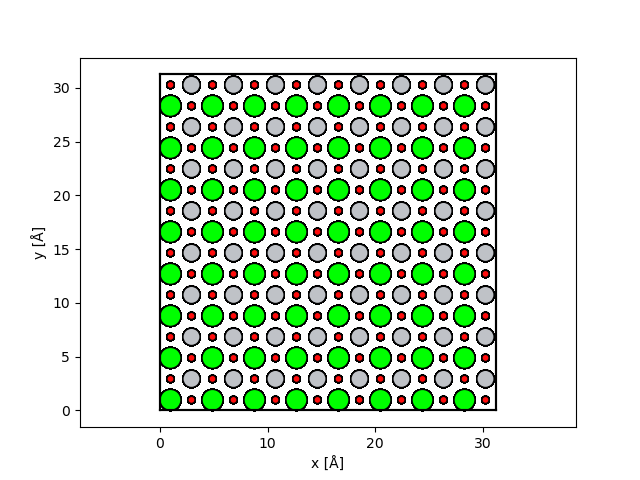

In [9]:
atom_pos = [(0.0, 0.0, 0.0), (0.5, 0.5, 0.5), (0.5, 0.5, 0.0)]
srtio3 = ase.spacegroup.crystal(['Sr','Ti','O'], atom_pos, spacegroup=221, cellpar=3.905, size=(8, 8, 80))

srtio3.center()
print(f"Simulation cell: {srtio3.cell}")
abtem.show_atoms(srtio3);

### Defining the potential

In [13]:
potential = abtem.Potential(srtio3, 
                      gpts=512, 
                      slice_thickness=3.904/2, 
                      parametrization='kirkland', 
                      projection='infinite')

potential.sampling
wave = abtem.PlaneWave(energy=200e3, sampling=.05)

### Multislice

Potential:   0%|          | 0/313 [00:00<?, ?it/s]

Multislice:   0%|          | 0/313 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


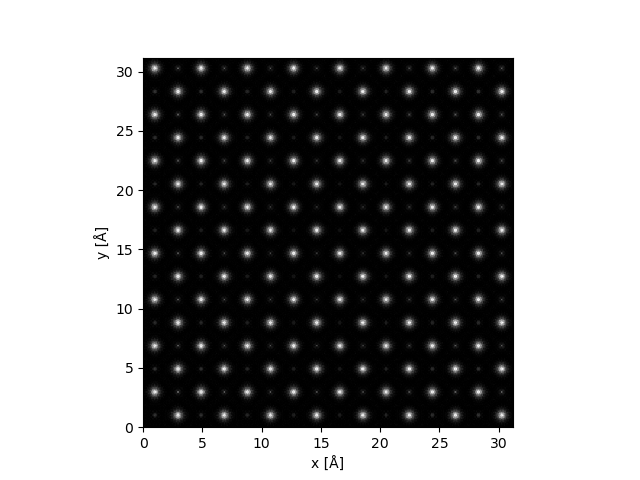

(<AxesSubplot:xlabel='x [Å]', ylabel='y [Å]'>,
 <matplotlib.image.AxesImage at 0x20b276fc280>)

In [14]:
exit_wave = wave.multislice(potential)
exit_wave.show()

### Plot Diffraciton Pattern

<IPython.core.display.Javascript object>


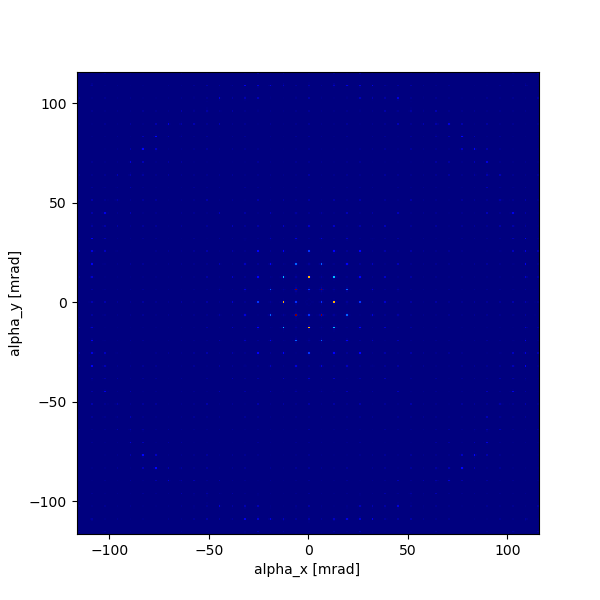

In [17]:
diffraction_pattern = exit_wave.diffraction_pattern()
diffraction_pattern = abtem.measure.block_zeroth_order_spot(diffraction_pattern)

ax, im = diffraction_pattern.show(power=.4, figsize=(6,6), cmap='jet')

## Thermal Diffuse Scattering
The atoms in any real material are not exactly located at their symmetrical lattice points due to thermal and zero-point vibrations. The ``frozen phonon`` approximation is a simple to simulate the effects of thermal vibrations. 

The scattering that is associated with thermal lattice vibrations is called ``thermal diffuse scattering (TDS)``.
In the following, we investigate the effect of thermal diffuse scattering in the frozen phonon approximation on diffraction pattern.

### Structure and Debey Waller Factor

Each atom is allowed to deviate from its symmetrical lattice position with a Gaussian distribution and
an ``root mean square`` **rms** deviation of $x_{RMS}$  in each of three directions. This is equivalent to the Einstein model of the density of states for phonons.

This standard deviation of this Gaussiam distribution $x_{RMS}$ for most materials is about 0.1Å:

The relation of the Debey-Waller Factors in the literature to the deviation of position $x_{RMS} = \sqrt{B/(8\pi^2)}$.

The ``FrozenPhonon class`` of the abtem package generates offsets from such a Gaussian distribution  using a random number generator with a given seed. 

The standard deviation of the Gaussian distribution is provided for each element as a dictionary.


In [19]:
# ------ Input ------ #
number_of_frozen_phonon_runs = 12
# --------------------#
frozen_phonons = abtem.FrozenPhonons(srtio3, number_of_frozen_phonon_runs, {'Sr' : .1, 'Ti' : .1, 'O' : .1}, seed=1)

<IPython.core.display.Javascript object>


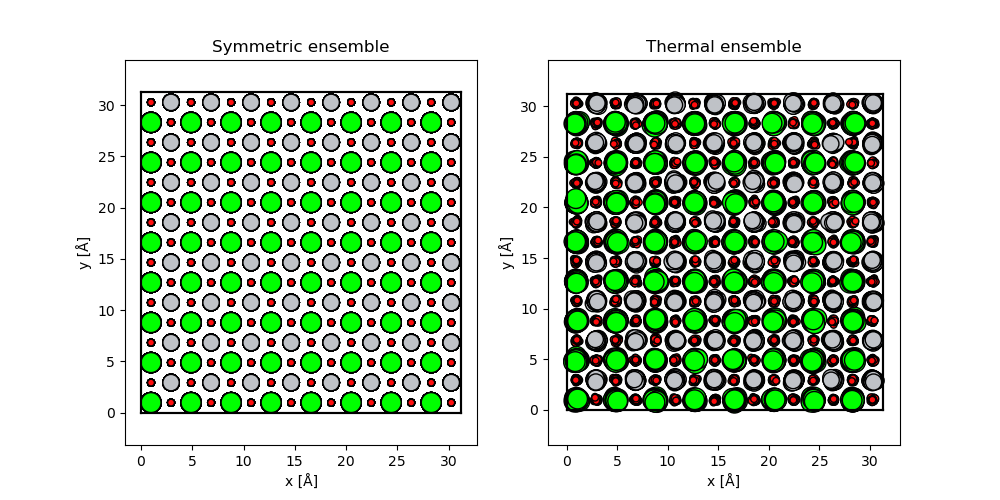

Text(0.5, 1.0, 'Thermal ensemble')

In [24]:
atoms_conf = next(iter(frozen_phonons))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

abtem.show_atoms(srtio3, ax=ax1)

abtem.show_atoms(atoms_conf, ax=ax2);
ax1.set_title('Symmetric ensemble')
ax2.set_title('Thermal ensemble');

### Building a potential 

In [27]:
tds_potential = abtem.Potential(frozen_phonons, gpts=512, slice_thickness=3.905/2, 
                                projection='infinite', parametrization='kirkland')
print(f"Real space sampling: {tds_potential.sampling}")

Real space sampling: (0.061015625, 0.061015625)


In [28]:
tds_exit_waves = wave.multislice(tds_potential, pbar=True)

TDS:   0%|          | 0/12 [00:00<?, ?it/s]

Multislice:   0%|          | 0/160 [00:00<?, ?it/s]

Potential:   0%|          | 0/160 [00:00<?, ?it/s]

### Averaging thermal diffuse scattering calculations.

The need for averaging of the thermal diffuse scattering becomes clear in  the following figure.

Each atom position has to have many deviations to be averaged out in the center. This is waht makes this process so long and what makes the process obvious for (embarrassingly) parallel methods.

<IPython.core.display.Javascript object>


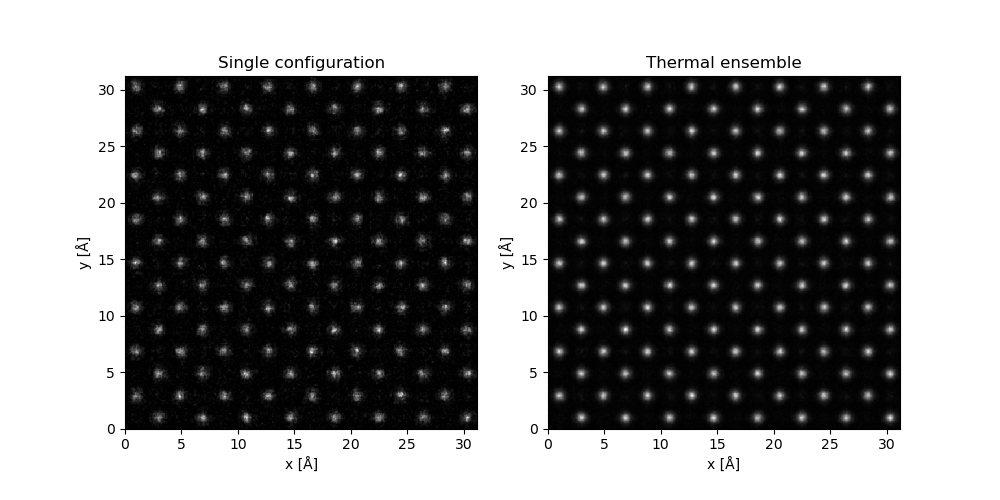

Text(0.5, 1.0, 'Thermal ensemble')

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

tds_exit_waves[0].show(ax=ax1)
ax1.set_title('Single configuration')
tds_exit_waves.intensity().mean(0).show(ax=ax2)
ax2.set_title('Thermal ensemble')

### Plot Diffraction Pattern

The Kikuchi notebook explained that the source for the Kikuchi pattern formation is inside the sample. Here we have the origin of this source. The thermal diffuse scattering makes the electrons scatter into high angles and that is needed to capture these features in a simulation. 

> So when you see Kikuchi bands you actually see the effect of phonons.


<IPython.core.display.Javascript object>


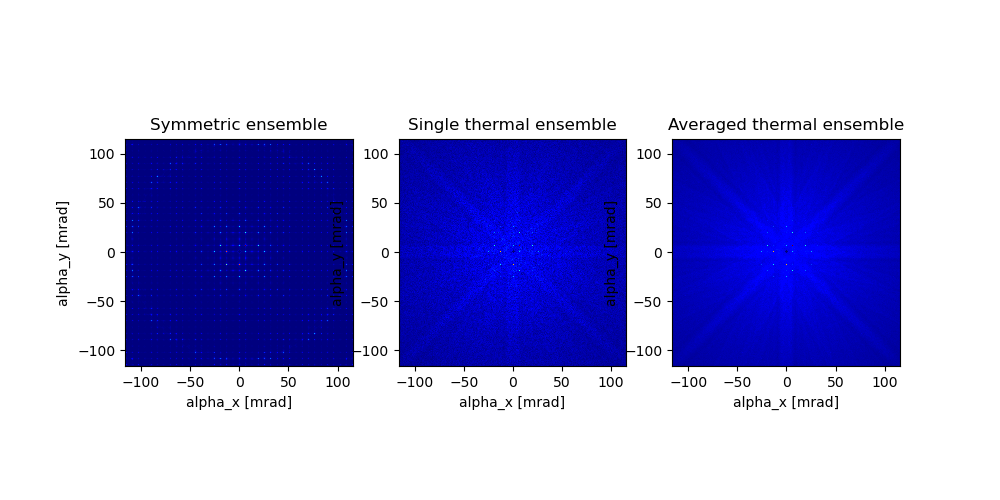

Text(0.5, 1.0, 'Averaged thermal ensemble')

In [69]:
tds_diffraction_pattern = tds_exit_waves.diffraction_pattern('valid', block_zeroth_order=True)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,5))

diffraction_pattern.show(power=.25, cmap='jet', ax=ax1)
ax1.set_title('Symmetric ensemble')
tds_diffraction_pattern[0].show(power=.25, cmap='jet', ax=ax2)
ax2.set_title('Single thermal ensemble')

tds_diffraction_pattern.mean(0).show(ax=ax3, cmap='jet', power=.25, )
ax3.set_title('Averaged thermal ensemble')

## CBED and Thermal Diffuse Scattering

### Symmetric ensemble

In [58]:
from abtem.waves import  Probe

probe = Probe(energy=80e3, semiangle_cutoff=20, rolloff=0.1, defocus=40, Cs=3e5, focal_spread=20)
pos = [0.,0.]
probe_exit_wave = probe.multislice(positions=pos, potential=potential, pbar=True)


Potential:   0%|          | 0/313 [00:00<?, ?it/s]

Multislice:   0%|          | 0/313 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


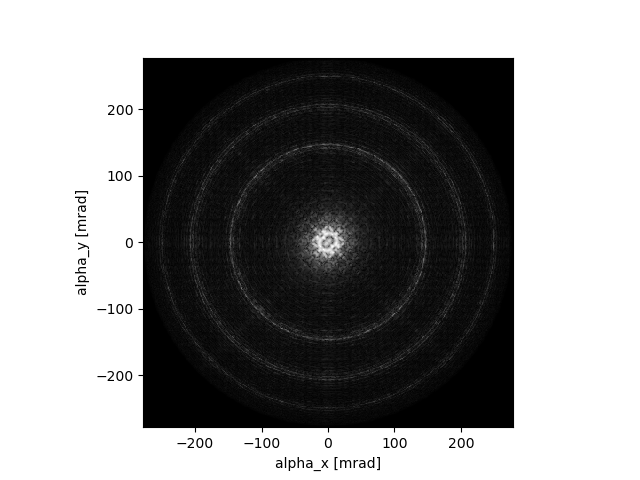

(<AxesSubplot:xlabel='alpha_x [mrad]', ylabel='alpha_y [mrad]'>,
 <matplotlib.image.AxesImage at 0x20b2a268ee0>)

In [72]:
from abtem.detect import PixelatedDetector
detector = PixelatedDetector(max_angle='limit')
cbed = probe.build().multislice(potential, pbar=True, detector=detector)
cbed.show(power=0.25)

### TDS

TDS:   0%|          | 0/12 [00:00<?, ?it/s]

Multislice:   0%|          | 0/160 [00:00<?, ?it/s]

Potential:   0%|          | 0/160 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


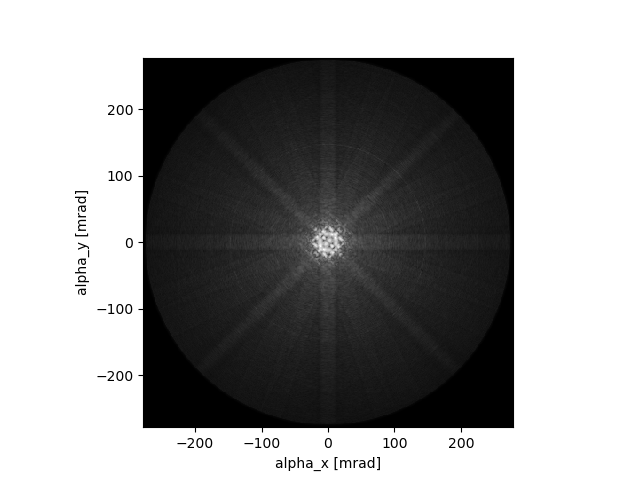

(<AxesSubplot:xlabel='alpha_x [mrad]', ylabel='alpha_y [mrad]'>,
 <matplotlib.image.AxesImage at 0x20b294a9790>)

In [76]:
detector = PixelatedDetector(max_angle='limit')
tds_cbed = probe.build().multislice(tds_potential, pbar=True, detector=detector)
tds_cbed.mean(0).show(power=0.25)

### Comparison

<IPython.core.display.Javascript object>


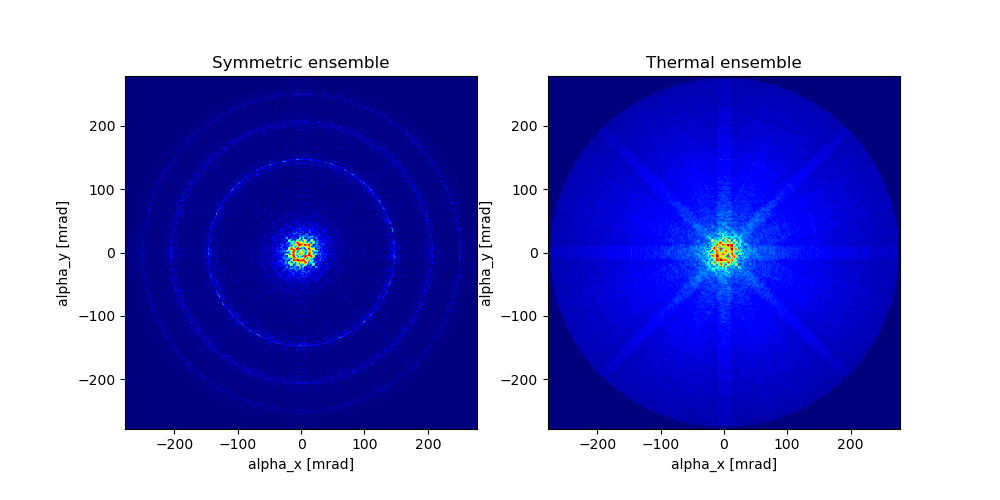

Text(0.5, 1.0, 'Thermal ensemble')

In [79]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

cbed.show(power=.4, cmap='jet', ax=ax1)
ax1.set_title('Symmetric ensemble')
tds_cbed.show(power=.3, cmap='jet', ax=ax2)
ax2.set_title('Thermal ensemble')

### Geometry of High-Angle Annular Dark-Field Detector

To do Z-contrast iamging we scan the probe and use the high-angle annular dark-field detector tocollect the image intensity pixel by pixel. 

In the next figure only the part of the CBED pattern that the HAADF is integrating over is shown.



## Summary

For a quantitative image simulation we need to do dynamic scattering theory. 

The dynamic scattering theory is done within the multislice algorithm that treats each slice like a weak phase object.


>
> Thermal defuse scattering needs to be included into the multislice calculations for a good simulation
>

The thermal diffuse scattering can be approximated by the frozen phonon approximation but it is computationally intensive.